In [21]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

pandas2ri.activate()

In [22]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('exec_optim_semidist.R')

# Loading the function we have defined in R.
exec_function_r = robjects.globalenv['eval_basin_param']
get_basin_q = robjects.globalenv['get_basin_q']

Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
info_str = "full_qmm_5043"

result_files = [
    (f"./results/new_data/config_{info_str}_0_MSE.csv",0,"MSE"),
    (f"./results/new_data/config_{info_str}_1_MSE.csv",1,"MSE"),
    (f"./results/new_data/config_{info_str}_2_MSE.csv",2,"MSE"),
    (f"./results/new_data/config_{info_str}_3_MSE.csv",3,"MSE"),
    (f"./results/new_data/config_{info_str}_0_NSE.csv",0,"NSE"),
    (f"./results/new_data/config_{info_str}_1_NSE.csv",1,"NSE"),
    (f"./results/new_data/config_{info_str}_2_NSE.csv",2,"NSE"),
    (f"./results/new_data/config_{info_str}_3_NSE.csv",3,"NSE"),
    (f"./results/new_data/config_{info_str}_0_R2.csv",0,"R2"),
    (f"./results/new_data/config_{info_str}_1_R2.csv",1,"R2"),
    (f"./results/new_data/config_{info_str}_2_R2.csv",2,"R2"),
    (f"./results/new_data/config_{info_str}_3_R2.csv",3,"R2"),
    (f"./results/new_data/config_{info_str}_0_KGE.csv",0,"KGE"),
    (f"./results/new_data/config_{info_str}_1_KGE.csv",1,"KGE"),
    (f"./results/new_data/config_{info_str}_2_KGE.csv",2,"KGE"),
    (f"./results/new_data/config_{info_str}_3_KGE.csv",3,"KGE"),
]

# result_files_new = list(map(lambda x: x.replace(".", "_long."), result_files))

In [24]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv("data/CHGbasins.txt")
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "basin_idx", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        params = np.loadtxt(file_name, delimiter=",", max_rows=1).reshape([len(basin_df),-1])

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]
            
            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]
            
            if codedown not in agg_q:
                agg_q[codedown] = 0
            
            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics)

    

./results/new_data/config_full_qmm_5043_0_MSE.csv Yes
./results/new_data/config_full_qmm_5043_1_MSE.csv Yes
./results/new_data/config_full_qmm_5043_2_MSE.csv Yes
./results/new_data/config_full_qmm_5043_3_MSE.csv Yes
./results/new_data/config_full_qmm_5043_0_NSE.csv Yes
./results/new_data/config_full_qmm_5043_1_NSE.csv Yes
./results/new_data/config_full_qmm_5043_2_NSE.csv Yes
./results/new_data/config_full_qmm_5043_3_NSE.csv Yes
./results/new_data/config_full_qmm_5043_0_R2.csv Yes
./results/new_data/config_full_qmm_5043_1_R2.csv Yes
./results/new_data/config_full_qmm_5043_2_R2.csv Yes
./results/new_data/config_full_qmm_5043_3_R2.csv Yes
./results/new_data/config_full_qmm_5043_0_KGE.csv Yes
./results/new_data/config_full_qmm_5043_1_KGE.csv Yes
./results/new_data/config_full_qmm_5043_2_KGE.csv Yes
./results/new_data/config_full_qmm_5043_3_KGE.csv Yes


In [25]:
eval_df["basin_idx"] = eval_df["basin_idx"].astype(str)

In [26]:
eval_df[eval_df["target"] == "NSE"]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE
20,0,NSE,5029,23.903796,4.889151,-26.9,0.483804,0.604186,0.433487
21,0,NSE,5054,6.318329,2.513629,2134.2,-36.011829,0.201151,-20.432784
22,0,NSE,5060,91.733745,9.577774,297.1,-15.126344,0.467779,-3.023645
23,0,NSE,5071,7.467238,2.732625,-22.2,0.788699,0.842235,0.717288
24,0,NSE,5043,3709.646940,60.906871,158.6,-19.642992,0.206025,-2.587994
25,1,NSE,5029,23.899810,4.888743,-26.9,0.483890,0.604241,0.433599
26,1,NSE,5054,0.273111,0.522600,341.0,-0.599844,0.184040,-2.488724
27,1,NSE,5060,2.755138,1.659861,61.1,0.515660,0.792865,0.374904
28,1,NSE,5071,10.390576,3.223442,-29.6,0.705977,0.855164,0.552924
29,1,NSE,5043,3517.543117,59.308879,160.7,-18.573996,0.113928,-2.357940


In [27]:
eval_df[eval_df["basin_idx"] == "5043"]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE
4,0,MSE,5043,4614.153517,67.927561,279.3,-24.676280,0.422630,-2.561480
9,1,MSE,5043,1966.977727,44.350623,116.1,-9.945599,0.173168,-1.419365
14,2,MSE,5043,1637.537026,40.466493,156.1,-8.112367,0.370264,-1.028562
19,3,MSE,5043,2291.821895,47.872977,203.3,-11.753252,0.383516,-1.349338
24,0,NSE,5043,3709.646940,60.906871,158.6,-19.642992,0.206025,-2.587994
29,1,NSE,5043,3517.543117,59.308879,160.7,-18.573996,0.113928,-2.357940
34,2,NSE,5043,190.157704,13.789768,-12.7,-0.058166,0.242015,0.476412
39,3,NSE,5043,2633.998432,51.322494,195.7,-13.657354,0.310389,-1.659834
44,0,R2,5043,3309.888178,57.531628,224.4,-17.418463,0.427949,-2.065009
49,1,R2,5043,2693.882883,51.902629,201.5,-13.990592,0.458765,-1.754983


In [28]:
eval_df.to_csv("full_qmm_5043_table.txt", index=False)

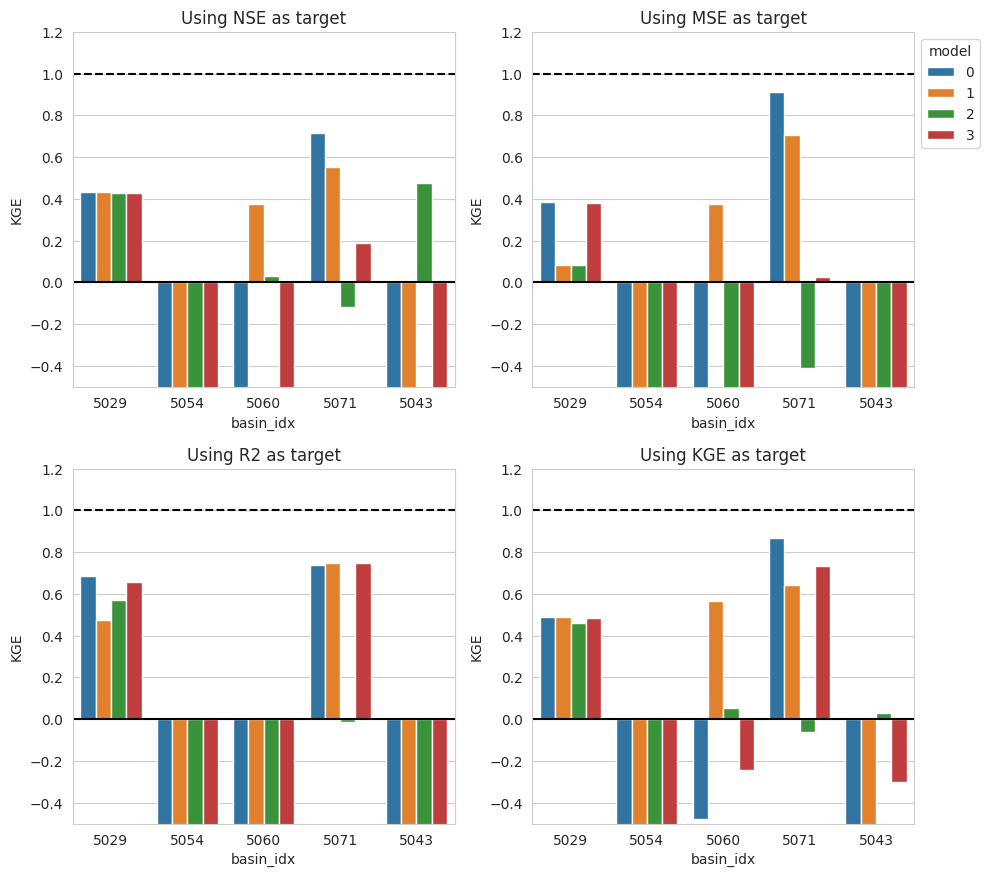

In [31]:
fig, axes = plt.subplots(2,2,figsize=(10, 10))


metric_measure = "KGE"
for idx, metric in enumerate(["NSE", "MSE", "R2", "KGE"]):    
    ax = axes[idx//2, idx%2]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][['basin_idx', 'model', metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="basin_idx", y=metric_measure, hue="model", ax=ax)
    hist_ax.set(title = f"Using {metric} as target")


    if idx == 1:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
    

    if metric_measure == "Pbias":
        hist_ax.set(ylim = [-27, 27], yticks = range(-25,30,5))
        ax.axhline(0, color="k")

plt.show()